# Assignment 6

With data file illinimensbb.csv, build a logistic regression model for field goals, and a Poisson loglinear regression model for shots blocked, using JAGS and rjags.

## 1. display box plots of height by position.
As the plot shows, there is a relationship between height and position, shorter players are tend to play at guard position whereas taller players are playing forward position.

In [1]:
game <- read.csv(file = 'illinimensbb.csv',header = TRUE)

In [2]:
head(game)

X,Player,Ht,Pos,MIN,FGM,FGA,BLK
0,DJ Williams,79,G,150,17,40,5
1,Jaylon Tate,75,G,408,18,47,2
2,Kipper Nichols,78,F,286,39,86,7
3,Te'Jon Lucas,72,G,642,47,115,1
5,Jalen Coleman-Lands,75,G,850,94,257,4
12,Leron Black,79,F,627,101,223,3


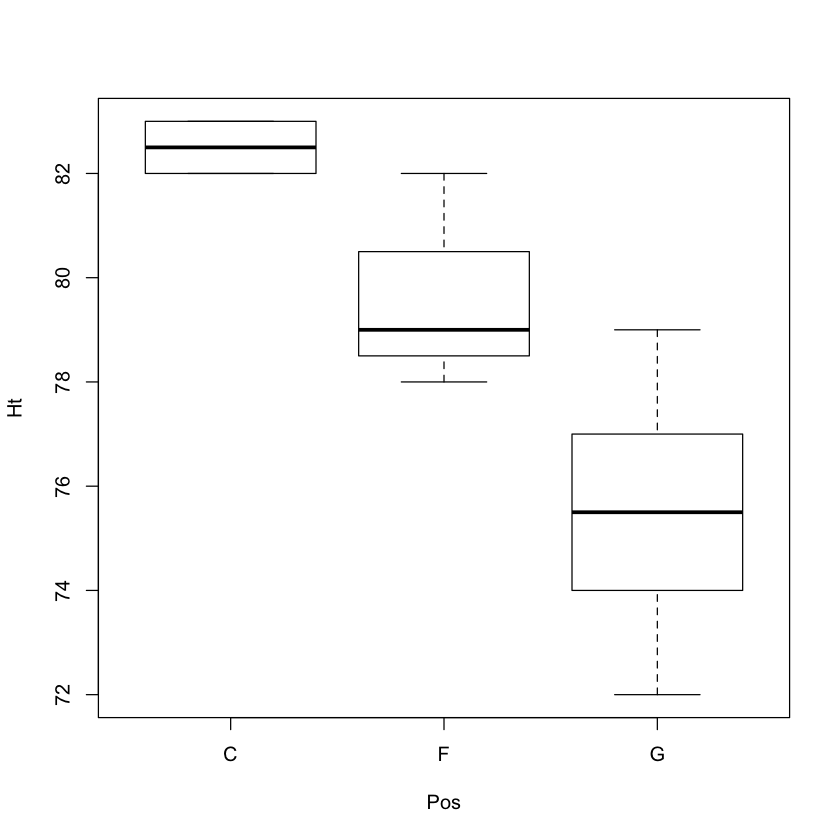

In [3]:
#display box plots of height by position
plot(Ht ~ Pos, data=game)

### 2. Logistic regression model for field goals  

![logisticModel](logisticModel.png)

**(a)** List an appropriate JAGS model.

In [4]:
levels(game$Pos)

[1] "C" "F" "G"

In [5]:
unclass(game$Pos)

[1] 3 3 2 3 3 2 3 3 1 3 1 3 3 2 3
attr(,"levels")
[1] "C" "F" "G"

In [ ]:
#List an appropriate JAGS model
#game1.bug
'
model {
  for (i in 1:length(fgm)) {
    fgm[i] ~ dbin(prob[i], fga[i])
    logit(prob[i]) <- betapos[pos[i]] + betaheight*heightcaled[i]
    fgmrep[i] ~ dbin(prob[i], fga[i])
  }
  for (j in 1:max(pos)) {
    betapos[j] ~ dt(0, 0.01, 1)
  }
  betaheight ~ dt(0, 0.16, 1)
}
'

In [6]:
d1 <- list(fgm = game$FGM,
            fga = game$FGA,
            pos = unclass(game$Pos),
            heightcaled = as.vector(scale(game$Ht, scale=2*sd(game$Ht))))

In [7]:
inits1 <- list(list(betapos=c(10,10,10), betaheight=10),
                list(betapos=c(10,10,-10), betaheight=-10),
                list(betapos=c(10,-10,10), betaheight=-10),
                list(betapos=c(10,-10,-10), betaheight=10))

In [8]:
library(rjags)

Loading required package: coda
Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [9]:
m1 <- jags.model("game1.bug", d1, inits1, n.chains=4, n.adapt=1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 19
   Total graph size: 116

Initializing model



In [10]:
update(m1, 1000)  # burn-in

In [11]:
x1 <- coda.samples(m1, c("betapos","betaheight"), n.iter=2000)

In [12]:
gelman.diag(x1, autoburnin=FALSE)

Potential scale reduction factors:

           Point est. Upper C.I.
betaheight          1       1.00
betapos[1]          1       1.00
betapos[2]          1       1.00
betapos[3]          1       1.01

Multivariate psrf

1

In [13]:
x1 <- coda.samples(m1, c("betapos","betaheight","prob","fgmrep"),
                    n.iter=10000)

In [14]:
effectiveSize(x1[,1:4])

betaheight betapos[1] betapos[2] betapos[3] 
  4862.217   5735.018   7799.221  11058.862

**(b)** Display the coda summary of the results for the monitored regression coefficients.  
Note that 1=C=center, 2=F=forward, 3=G=guard, therefore in the display below, $\beta_C$ is betapos[1], $\beta_F$ is betapos[2], $\beta_G$ is betapos[3], $\beta_{Ht}$ is betaheight.

In [15]:
summary(x1[,1:4])


Iterations = 4001:14000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 10000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

               Mean      SD  Naive SE Time-series SE
betaheight  0.15526 0.16853 0.0008427       0.002424
betapos[1]  0.05339 0.16285 0.0008143       0.002153
betapos[2] -0.20749 0.11260 0.0005630       0.001279
betapos[3] -0.34307 0.06785 0.0003393       0.000647

2. Quantiles for each variable:

              2.5%      25%      50%     75%    97.5%
betaheight -0.1750  0.04187  0.15566  0.2684  0.48528
betapos[1] -0.2678 -0.05676  0.05419  0.1634  0.37350
betapos[2] -0.4287 -0.28226 -0.20742 -0.1316  0.01385
betapos[3] -0.4765 -0.38902 -0.34287 -0.2966 -0.21065


**(c)** With your posterior samples, display scatterplots of   
(i) $\beta_C$ vs. $\beta_{Ht}$

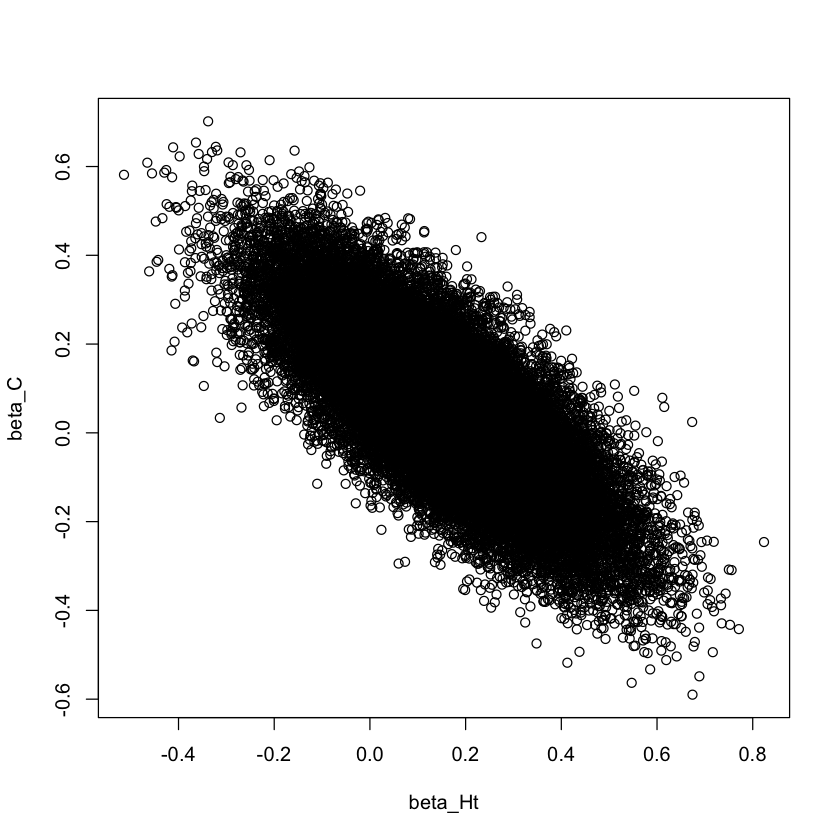

In [16]:
plot(as.matrix(x1[,2])~as.matrix(x1[,1]),
    xlab = "beta_Ht",
    ylab = "beta_C")

(ii) $\beta_F$ vs. $\beta_{Ht}$

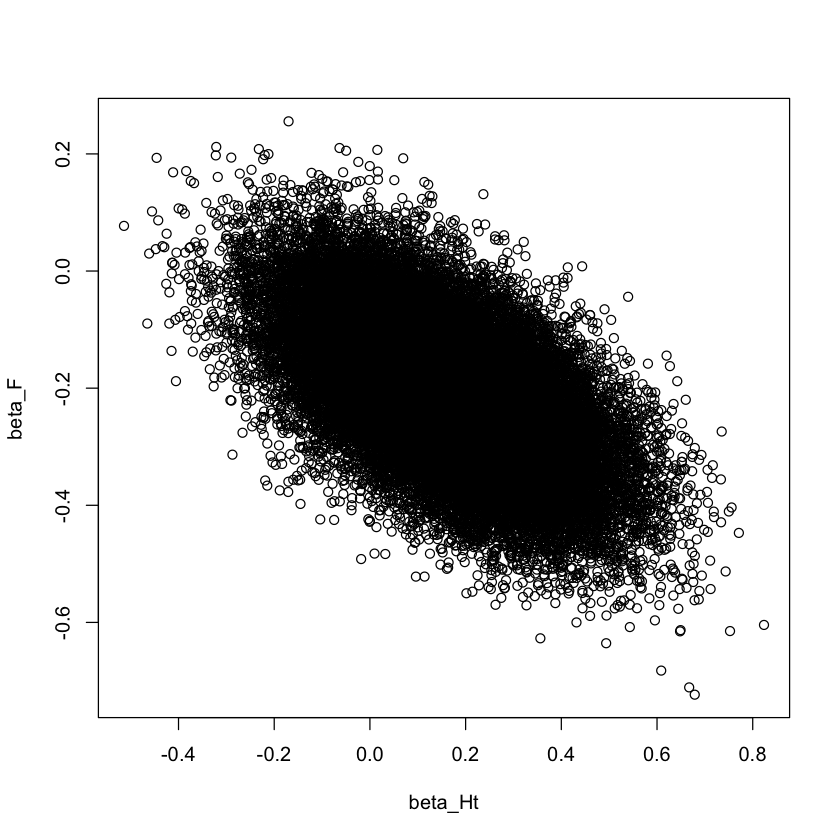

In [17]:
plot(as.matrix(x1[,3])~as.matrix(x1[,1]),
    xlab = "beta_Ht",
    ylab = "beta_F")

(ii) $\beta_G$ vs. $\beta_{Ht}$

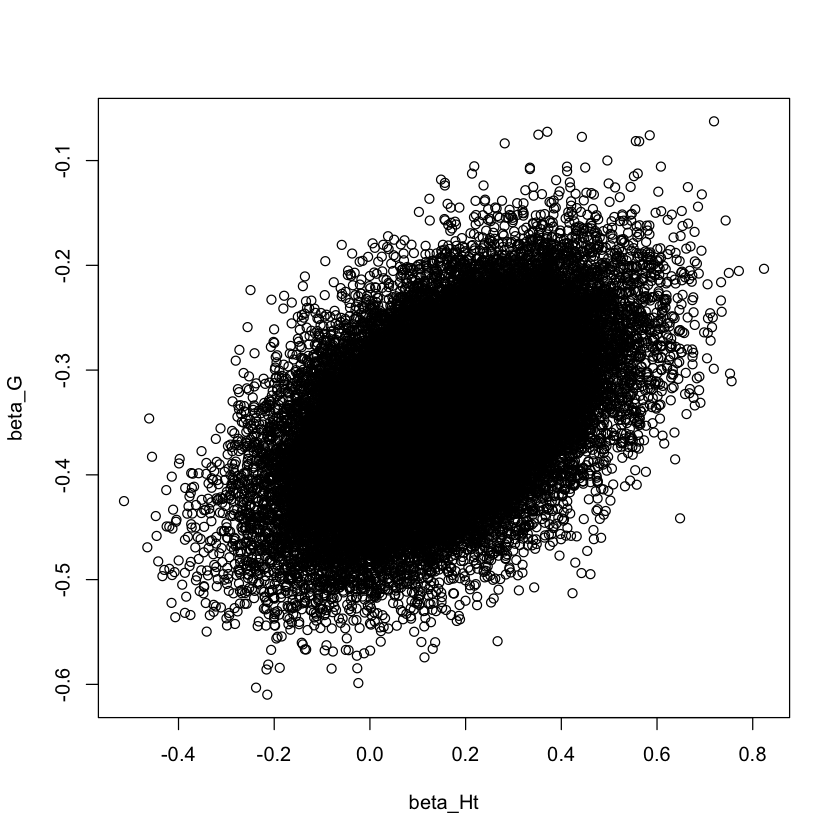

In [18]:
plot(as.matrix(x1[,4])~as.matrix(x1[,1]),
    xlab = "beta_Ht",
    ylab = "beta_G")

From those plots, I do see the (posterior) correlations between hights and postions that matches the initial box plot with the data.

**(d)** Consider the modeled probability that Maverick Morgan (No. 22) successfully makes an attempted field goal. Plot the (approximate) posterior density of this probability.

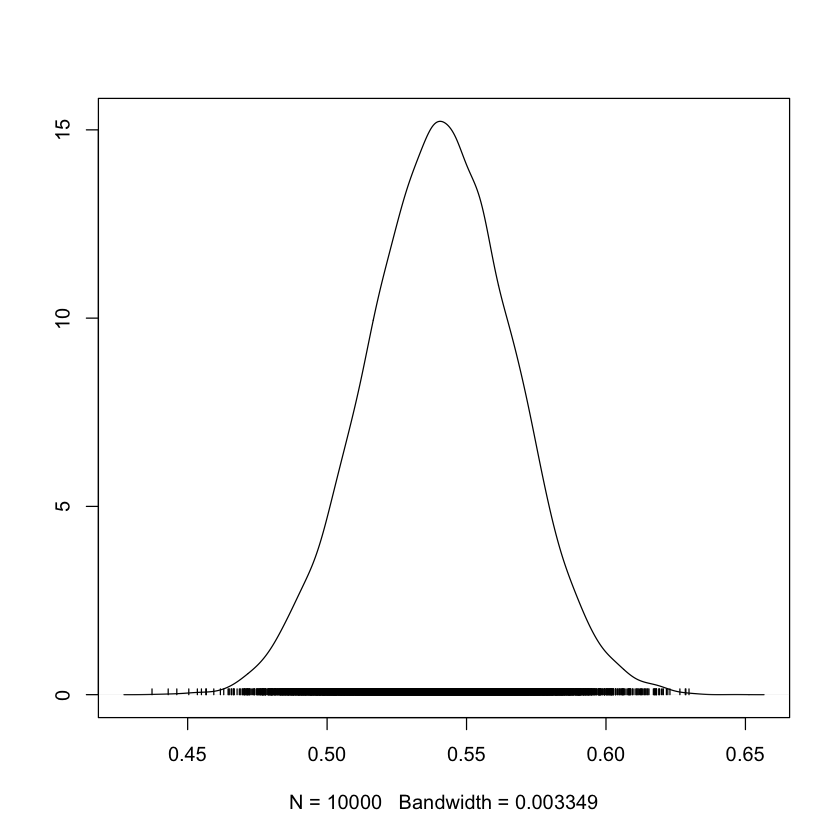

In [19]:
#Maverick Morgan (No. 22) is the 9th entry in the dataset
densplot(x1[,c("prob[9]")])

**(e)** Approximate the posterior probability that $\beta_C > \beta_G$.  
Also, approximate the Bayes factor favoring $\beta_C > \beta_G$ vs. $\beta_C < \beta_G$.  

$$
\begin{aligned}
\operatorname{BF}(H_2;H_1) =\frac{\text{posterior odds favoring}\space H_2}{\text{prior odds favoring}\space H_2} = 41.19
\end{aligned}
$$

Because BF value is between 20 to 150, it means that the data strongly suggest that $\beta_C > \beta_G$

In [20]:
#posterior probability
mean(as.matrix(x1[,2])>as.matrix(x1[,4]))

[1] 0.9763

In [21]:
#Bayes factor
mean(as.matrix(x1[,2])>as.matrix(x1[,4]))/mean(as.matrix(x1[,2])<as.matrix(x1[,4]))

[1] 41.19409

**(f)** Use the chi-square discrepancy to compute an approximate posterior predictive p-value. Based on the result showing below, p=0.781425, no overdispersion problems.

In [22]:
#For checking overdispersion, first extract the samples of the 
#fitted probabilities prob and the replicate responses fgmrep:
probs <- as.matrix(x1)[, paste("prob[",1:nrow(game),"]", sep="")]

In [23]:
fgmrep <- as.matrix(x1)[, paste("fgmrep[",1:nrow(game),"]", sep="")]

In [24]:
#Now compute samples of chi-square discrepancy 
#and replicated chi-square discrepancy:
Tchi <- numeric(nrow(fgmrep))
Tchirep <- numeric(nrow(fgmrep))

In [25]:
for(s in 1:nrow(fgmrep)){
Tchi[s] <- sum((game$FGM - game$FGA*probs[s,])^2 /
               (game$FGA*probs[s,]*(1-probs[s,])))
Tchirep[s] <- sum((fgmrep[s,] - game$FGA*probs[s,])^2 /
                  (game$FGA*probs[s,]*(1-probs[s,])))
    }

In [26]:
#compute a posterior predictive p-value for overdispersion
mean(Tchirep >= Tchi)

[1] 0.781425

**(g)** Use the rjags function dic.samples to compute the effective number of parameters (“penalty”) and Plummer’s DIC (“Penalized deviance”). Use at least 100,000 iterations. The actual number of regression coefficients is 4, whereas the effective number of parameters of this model is 3.976 , indicates we might need all two of those variables(postion and hight) to model the field goals made by player.

In [27]:
dic.samples(m1,100000)

Mean deviance:  77.91 
penalty 3.976 
Penalized deviance: 81.89 

**(h)** Now completely remove the height variable from the model (but keep everything else the same). List an appropriate JAGS model. Run it using rjags, with all of the usual steps, then use dic.samples to compute Plummer’s DIC (“Penalized deviance”). Use at least 100,000 iterations.   
As the results showing below, effective number of parameters of this model is 2.999, same as the actual number of regression coefficients 3, and Plummer’s DIC value is 80.76, which is slightly less than the previous model(81.89), overall, this model is simpler(less variables) and equally effective(same DIC), therefore this model is better, the height variable sames unecessary, because it is highly correlated with postion variables as the results showed earlier.

In [ ]:
#game2.bug
'
model {
  for (i in 1:length(fgm)) {
    fgm[i] ~ dbin(prob[i], fga[i])
    logit(prob[i]) <- betapos[pos[i]]
    fgmrep[i] ~ dbin(prob[i], fga[i])
  }
  for (j in 1:max(pos)) {
    betapos[j] ~ dt(0, 0.01, 1)
  }
}
'

In [40]:
d2 <- list(fgm = game$FGM,
            fga = game$FGA,
            pos = unclass(game$Pos))

In [41]:
inits2 <- list(list(betapos=c(10,10,10)),
                list(betapos=c(10,10,-10)),
                list(betapos=c(10,-10,10)),
                list(betapos=c(10,-10,-10)))

In [42]:
m2 <- jags.model("game2.bug", d2, inits2, n.chains=4, n.adapt=1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 18
   Total graph size: 69

Initializing model



In [31]:
update(m2, 1000)  # burn-in

In [32]:
x2 <- coda.samples(m2, c("betapos"), n.iter=2000)

In [33]:
gelman.diag(x2, autoburnin=FALSE)

Potential scale reduction factors:

           Point est. Upper C.I.
betapos[1]          1          1
betapos[2]          1          1
betapos[3]          1          1

Multivariate psrf

1

In [34]:
x2 <- coda.samples(m2, c("betapos","prob","fgmrep"),
                    n.iter=10000)

In [35]:
effectiveSize(x2[,1:3])

betapos[1] betapos[2] betapos[3] 
  24433.08   25425.19   24259.98

In [36]:
probs <- as.matrix(x2)[, paste("prob[",1:nrow(game),"]", sep="")]
fgmrep <- as.matrix(x2)[, paste("fgmrep[",1:nrow(game),"]", sep="")]
Tchi <- numeric(nrow(fgmrep))
Tchirep <- numeric(nrow(fgmrep))

In [37]:
for(s in 1:nrow(fgmrep)){
Tchi[s] <- sum((game$FGM - game$FGA*probs[s,])^2 /
               (game$FGA*probs[s,]*(1-probs[s,])))
Tchirep[s] <- sum((fgmrep[s,] - game$FGA*probs[s,])^2 /
                  (game$FGA*probs[s,]*(1-probs[s,])))
    }

In [38]:
#compute a posterior predictive p-value for overdispersion
mean(Tchirep >= Tchi)

[1] 0.796825

In [39]:
dic.samples(m2,100000)

Mean deviance:  77.76 
penalty 2.999 
Penalized deviance: 80.76 

### 3. Poisson loglinear regression model for shots blocked

![PoissonLoglinear](loglinear.png)

**(a)** List an appropriate JAGS model.

In [ ]:
#game3.bug
'
model {
  for (i in 1:length(blk)) {
    blk[i] ~ dpois(lambda[i])
    log(lambda[i]) <- logmin[i] + betapos[pos[i]] + betaheight*heightcaled[i]
  blkrep[i] ~ dpois(lambda[i])
}
  for (i in 1:max(pos)) {
    betapos[i] ~ dnorm(0, 1/100^2)
  }
  betaheight ~ dnorm(0, 1/100^2)
}
'

In [43]:
d3 <- list(blk = game$BLK,
           logmin = log(game$MIN),
            pos = unclass(game$Pos),
            heightcaled = as.vector(scale(game$Ht)))

In [44]:
inits3 <- list(list(betapos=c(10,10,10), betaheight=10),
                list(betapos=c(10,10,-10), betaheight=-10),
                list(betapos=c(10,-10,10), betaheight=-10),
                list(betapos=c(10,-10,-10), betaheight=10))

In [45]:
m3 <- jags.model("game3.bug", d3, inits3, n.chains=4, n.adapt=1000)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 15
   Unobserved stochastic nodes: 19
   Total graph size: 124

Initializing model



In [46]:
update(m3, 1000)  # burn-in

In [47]:
x3 <- coda.samples(m3, c("betapos","betaheight"), n.iter=2000)

In [48]:
gelman.diag(x3, autoburnin=FALSE)

Potential scale reduction factors:

           Point est. Upper C.I.
betaheight          1       1.01
betapos[1]          1       1.01
betapos[2]          1       1.00
betapos[3]          1       1.00

Multivariate psrf

1

In [49]:
x3 <- coda.samples(m3, c("betapos","betaheight","lambda","blkrep"),
                    n.iter=30000)

In [50]:
effectiveSize(x3[,1:4])

betaheight betapos[1] betapos[2] betapos[3] 
  5658.657   5923.916  10244.243  22714.011

**(b)** Display the coda summary of the results for the monitored regression coefficients.

In [51]:
summary(x3[,1:4])


Iterations = 4001:34000
Thinning interval = 1 
Number of chains = 4 
Sample size per chain = 30000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

             Mean     SD  Naive SE Time-series SE
betaheight  0.551 0.2514 0.0007258       0.003343
betapos[1] -4.349 0.4097 0.0011826       0.005324
betapos[2] -5.173 0.3578 0.0010327       0.003540
betapos[3] -4.687 0.1963 0.0005667       0.001304

2. Quantiles for each variable:

               2.5%     25%     50%     75%  97.5%
betaheight  0.06285  0.3796  0.5488  0.7202  1.051
betapos[1] -5.15730 -4.6238 -4.3448 -4.0702 -3.558
betapos[2] -5.90491 -5.4074 -5.1626 -4.9263 -4.501
betapos[3] -5.08826 -4.8156 -4.6811 -4.5522 -4.319


**(c)** The sampling model implies that

$$
\begin{aligned}
e^{\beta_{Ht}}
\end{aligned}
$$

represents the factor by which the mean rate of blocking shots changes for each increase in height of one standard deviation (here, about 3.4 inches). 
Based on the result above, the 95% central posterior credible interval for $\beta_{Ht}$ is (0.06285, 1.051), therefore 95% central posterior credible interval for this factor is (1.065, 2.861), indicates that greater height is associated with a higher rate of blocking shots. 

In [52]:
exp(0.06285)

[1] 1.064867

In [53]:
exp(1.051)

[1] 2.86051

**(d)** Perform a chi-square posterior predictive check for overdispersion, the posterior predictive p-value is 0.9999, no sign of overdispersion problem.

In [54]:
lambdas <- as.matrix(x3)[, paste("lambda[",1:nrow(game),"]", sep="")]

In [55]:
blkrep <- as.matrix(x3)[, paste("blkrep[",1:nrow(game),"]",
                                       sep="")]

In [56]:
Tchi <- numeric(nrow(blkrep))

In [57]:
Tchirep <- numeric(nrow(blkrep))

In [58]:
for(s in 1:nrow(game)){
   Tchi[s] <- sum((game$BLK - lambdas[s,])^2 / lambdas[s,])
 Tchirep[s] <- sum((blkrep[s,] - lambdas[s,])^2 / lambdas[s,]) 
}

In [59]:
mean(Tchirep >= Tchi)

[1] 0.9998833

**(e)** For each player (i), approximate $\operatorname{Pr}(y^{rep}_i \geq y_i \mid y)$, which is a kind of marginal posterior predictive p-value.  

(i) Show your R code, and display a table with the player names and their values of this probability.

In [64]:
P <- numeric(nrow(game))
for(s in 1:nrow(game)){
    P[s]<-mean(blkrep[,s]>=game$BLK[s])
}

In [65]:
player<-game$Player

In [66]:
df <- data.frame(player,P)

In [67]:
df

player,P
DJ Williams,0.05753333
Jaylon Tate,0.73293333
Kipper Nichols,0.00867500
Te'Jon Lucas,0.90698333
Jalen Coleman-Lands,0.78232500
Leron Black,0.82624167
Tracy Abrams,0.35014167
Malcolm Hill,0.46777500
Maverick Morgan,0.35235833
Aaron Jordan,0.77000833


(ii)Name any players for whom this probability is less than 0.05.  

Kipper Nichols, 0.00867500


(iii)Notice that the probability equals 1 for some players(Samson Oladimeji,Clayton Jones,Alex Austin). This is not surprising because all 3 of them didn't have recorded block in the data becuase of very short playing time(8, 11, 20 min respectively).